## Import MXNET libraries and some other dependencies.
In the next block, I will download the resnet model as the pretrained model for image recognition then I will use it to carry out a transfer learning of the flower species recognition. In this demo, I will also be using CloudWatch to monitor the model performance through CloudWatch Dashboard.

In [51]:
import os, urllib
import mxnet as mx
import sagemaker_cw
from sagemaker_cw import CWEvalMetrics
import boto3, botocore

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)
#create s3 bucket
id = boto3.client('sts').get_caller_identity().get('Account')
bucket = id + "-sagemaker-devlabs"


# check if the bucket exists
try:
    s3 = boto3.client("s3")
    s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={'LocationConstraint': 'us-west-2'})
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!' + str(e))
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        print("The bucket already exist, go ahead and run the next cell. ")
else:
    print('Training input/output will be stored in: s3://{}/'.format(bucket))

The bucket already exist, go ahead and run the next cell. 


## Load the pre-trained ResNet model and make it ready for training on flowers
I simply use the MXNet Model load_checkpoint function to load the 50 layers pre-trained model.

In [38]:
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

## (Optional) Visualize the ResNet pretrained model
This step is an optional step to visualize the ResNet network. You can also compare the network before and after we do the Transfer Learning process

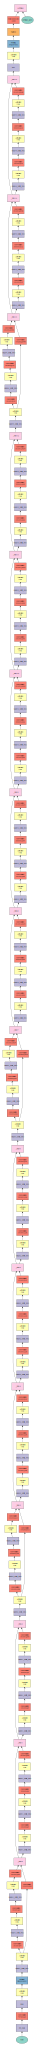

In [39]:
mx.viz.plot_network(sym)

## Create a dataset iterator
We will create MXNet dataset iteration to iterate on the images in the dataset. The dataset has been prepared and processed in the RecordIO format as discussed in the instructions guide.

In [40]:
def get_iterators(batch_size, data_shape=(3, 224, 224)):
    train = mx.io.ImageRecordIter(
        path_imgrec         = './dataset/102flowers-train.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = './dataset/102flowers-valid.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val)

## Define the transfer knowledge function
In this function, we will replace the output layer with a new layer that has the new number of classes.

In [41]:
def transfer_knowledge_to_model(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pre-trained network symbol
    arg_params: the argument parameters of the pre-trained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = sym.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)


## Define the hyperparameters

In [42]:
hyperparameters={'batch_size': 100, 
                         'epochs': 5,
                         'kvstore': 'device',
                         'optimizer':  'sgd',
                         'learning_rate': 0.01, 
                         'momentum': 0.9, 
                         'log_interval': 100}

## Define performance monitoring function using CloudWatch
In this function, we will integrate the Model performance metrics with CloudWatch by sending the trainging metrics and visualizing the performance

In [43]:
import time
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
cw_logger = logging.getLogger('botocore')
cw_logger.setLevel(logging.CRITICAL)
head = '%(asctime)-15s %(message)s'
last_count = 0
frequent = 10
init = False
tic = 0

def log_train_metric(auto_reset=False, hyperparameters=hyperparameters):
    batch_size = hyperparameters.get('batch_size')
    auto_reset = auto_reset
    
    def _callback(param):
        """The checkpoint function."""
        global last_count
        global frequent
        global init
        global tic
        count = param.nbatch
        if last_count > count:
            init = False
        else:
            init = True
        last_count = count
        if init:
            if count % frequent == 0:
                speed = frequent * batch_size / (time.time() - tic)
                if param.eval_metric is not None:
                    name_value = param.eval_metric.get_name_value()
                    if auto_reset:
                        param.eval_metric.reset()
                    for name, acc_value in name_value:
                        #logging.info('Iter[%d] Batch[%d] Train-%s=%f',
                         #        param.epoch, param.nbatch, name, acc_value)
                        CWMetrics = CWEvalMetrics()
                        CWMetrics.CW_eval(model_name='sydsummit1',is_training=True, Accuracy=acc_value * 100, Loss=0, hyperparameters=hyperparameters)
                    if auto_reset:
                        param.eval_metric.reset()
                    msg = 'Epoch[%d] Batch [%d]\tSpeed: %.2f samples/sec'
                    msg += '\t%s=%f'*len(name_value)
                    logging.info(msg, param.epoch, count, speed, *sum(name_value, ()))
                else:
                    logging.info("Iter[%d] Batch [%d]\tSpeed: %.2f samples/sec",
                                 param.epoch, count, speed)
                tic = time.time()
            else:
                init = True
                tic = time.time()
    return _callback

## Define the training function and setting the hyperparameters

In [44]:
num_classes = 102
batch_per_gpu = 20
num_gpus = 1
def fit(symbol, arg_params, aux_params, train, val, batch_size, num_gpus):
    devs = [mx.gpu(i) for i in range(num_gpus)]
    mod = mx.mod.Module(symbol=new_sym, context=devs)
    epochs = hyperparameters.get('epochs')
    mod.fit(train, val, 
        num_epoch=epochs,
        arg_params=arg_params,
        aux_params=aux_params,
        allow_missing=True,
        #batch_end_callback = mx.callback.Speedometer(batch_size, 10),
        batch_end_callback = log_train_metric(),
        eval_metric='acc',
        kvstore='device',
        optimizer='sgd',
        epoch_end_callback  = mx.callback.do_checkpoint("102flowers", 1),
        optimizer_params={'learning_rate':0.01},
        initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2))
    metric = mx.metric.Accuracy()
    return mod.score(val, metric)
(new_sym, new_args) = transfer_knowledge_to_model(sym, arg_params, num_classes)
batch_size = batch_per_gpu * num_gpus
(train, val) = get_iterators(batch_size)

## (Optional) Visualize the new network

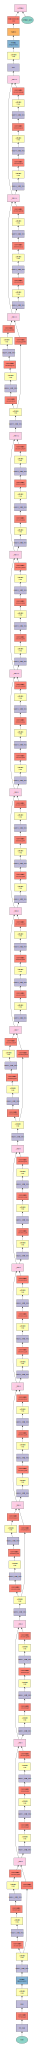

In [45]:
mx.viz.plot_network(new_sym)

## Start the model training
The training process should take about 4-5 minutes to finish. It will save a checkpoint after each EPOCH and you will get the last checkpoint and upload it to S3.

In [46]:
!date
mod_score = fit(new_sym, new_args, aux_params, train, val, batch_size, num_gpus)
!date

Mon Jul  2 00:30:21 UTC 2018


INFO:root:Epoch[0] Batch [0]	Speed: 0.00 samples/sec	accuracy=0.000000
INFO:root:Epoch[0] Batch [10]	Speed: 13492.36 samples/sec	accuracy=0.045455
INFO:root:Epoch[0] Batch [20]	Speed: 13210.74 samples/sec	accuracy=0.085714
INFO:root:Epoch[0] Batch [30]	Speed: 13275.47 samples/sec	accuracy=0.103226
INFO:root:Epoch[0] Batch [40]	Speed: 13336.38 samples/sec	accuracy=0.130488
INFO:root:Epoch[0] Batch [50]	Speed: 13109.25 samples/sec	accuracy=0.156863
INFO:root:Epoch[0] Batch [60]	Speed: 13101.88 samples/sec	accuracy=0.186066
INFO:root:Epoch[0] Batch [70]	Speed: 13482.91 samples/sec	accuracy=0.208451
INFO:root:Epoch[0] Batch [80]	Speed: 13038.30 samples/sec	accuracy=0.235185
INFO:root:Epoch[0] Batch [90]	Speed: 13208.45 samples/sec	accuracy=0.259890
INFO:root:Epoch[0] Batch [100]	Speed: 13247.83 samples/sec	accuracy=0.288119
INFO:root:Epoch[0] Batch [110]	Speed: 13270.51 samples/sec	accuracy=0.304955
INFO:root:Epoch[0] Batch [120]	Speed: 13557.30 samples/sec	accuracy=0.321488
INFO:root:Epoc

INFO:root:Epoch[3] Batch [100]	Speed: 13489.07 samples/sec	accuracy=0.970297
INFO:root:Epoch[3] Batch [110]	Speed: 13320.20 samples/sec	accuracy=0.968468
INFO:root:Epoch[3] Batch [120]	Speed: 13518.63 samples/sec	accuracy=0.969421
INFO:root:Epoch[3] Batch [130]	Speed: 13210.91 samples/sec	accuracy=0.970229
INFO:root:Epoch[3] Batch [140]	Speed: 13571.30 samples/sec	accuracy=0.970567
INFO:root:Epoch[3] Batch [150]	Speed: 13605.63 samples/sec	accuracy=0.971854
INFO:root:Epoch[3] Batch [160]	Speed: 13099.30 samples/sec	accuracy=0.972671
INFO:root:Epoch[3] Batch [170]	Speed: 13468.75 samples/sec	accuracy=0.973977
INFO:root:Epoch[3] Batch [180]	Speed: 13452.81 samples/sec	accuracy=0.974586
INFO:root:Epoch[3] Batch [190]	Speed: 13131.62 samples/sec	accuracy=0.974346
INFO:root:Epoch[3] Batch [200]	Speed: 13584.75 samples/sec	accuracy=0.974129
INFO:root:Epoch[3] Batch [210]	Speed: 13491.28 samples/sec	accuracy=0.974408
INFO:root:Epoch[3] Batch [220]	Speed: 13568.88 samples/sec	accuracy=0.974661

Mon Jul  2 00:32:27 UTC 2018


## Upload the model artifacts to S3
We will use the model artifact later on in the deployment stage

In [52]:
print(bucket)
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

epochs = hyperparameters.get('epochs')
model_fname = "102flowers-000" + str(epochs) + ".params"
upload_to_s3('artifacts', model_fname)
upload_to_s3('artifacts', '102flowers-symbol.json')

599334232150-sagemaker-devlabs


## Deploy the model
There are two ways to deploy the model artifacts:

1- Deploy the model through Sagemaker by running the "estimator.deploy()" function. (BUT, that's too easy')

2- Deploy a complete serverless endpoint using Lambda and API Gateway (That's so much cooler, cost effective and it's an on-demand endpoint)

I've create a CloudFormation template to deploy the serverless stack to host our model. Click on the below link to lunch the stack and follow the default wizard.

[Deploy CloudFormation Template](https://console.aws.amazon.com/cloudformation/home?region=us-west-2#/stacks/new?stackName=Flowers-Recognition-Template&templateURL=https://s3-us-west-2.amazonaws.com/sagemaker-demo-sydsummit/demo-code/102flowers.template)

After the deployment is finished, get back to the Demo Instructions sheet.